# KNN Based Recommendation Model Using The Goodreads Books Dataset

[Goodreads-Books Dataset](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks)

The Goodreads dataset chosen offers a comprehensive list of books spanning the entire Goodreads website. Book datasets serve as an excellent basis for analysis and modeling. Every book contains within itself a variety of features that can be explored and compared against others, making this kind of project an interesting opportunity to experiment with those features and generate new insight.

## Scope
- What is the average rating across the books and is there a bias conferred from finishing a book
- Is there a possible relationship between a book's average rating (1-5) and the total number of ratings  
- Design a recommendation model that takes an input book title and outputs recommendations based on their similarity to the input

In [1]:
import pandas as pd
from fuzzywuzzy import process

df = pd.read_csv(r"C:\Users\minec\Desktop\books.csv", on_bad_lines='skip')

#there are a few bad lines in the file so we skip over these for a functional dataframe

c:\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df.head(3)


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [3]:
df.index = df['bookID']
df.replace(to_replace='J.K. Rowling/Mary GrandPré', value = 'J.K. Rowling', inplace=True)
df.shape


(11123, 12)

In [4]:
df.head(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


### Understanding and visualizing

In [5]:
df['title'].value_counts()

title
The Iliad                                               9
The Brothers Karamazov                                  9
The Odyssey                                             8
Anna Karenina                                           8
'Salem's Lot                                            8
                                                       ..
The Noonday Demon: An Atlas of Depression               1
The Noonday Demon: An Anatomy of Depression             1
My Secret: A PostSecret Book                            1
The Secret Lives of Men and Women: A PostSecret Book    1
Las aventuras de Tom Sawyer                             1
Name: count, Length: 10348, dtype: int64

<BarContainer object of 7 artists>

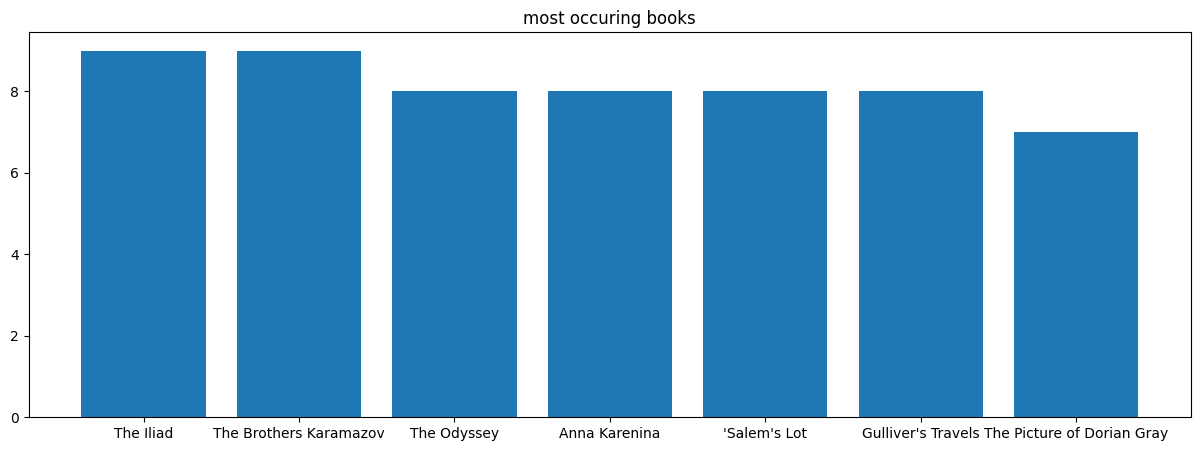

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.title('most occuring books')
plt.bar(df['title'].value_counts().index[:7], df['title'].value_counts()[:7])

Here we can see that The Iliad and The Brothers Karamazov have the most number of occurrences of the same title in the data. What this is representing is the various publication editions of classic titles that have clearly stood the test of time.  

<BarContainer object of 5 artists>

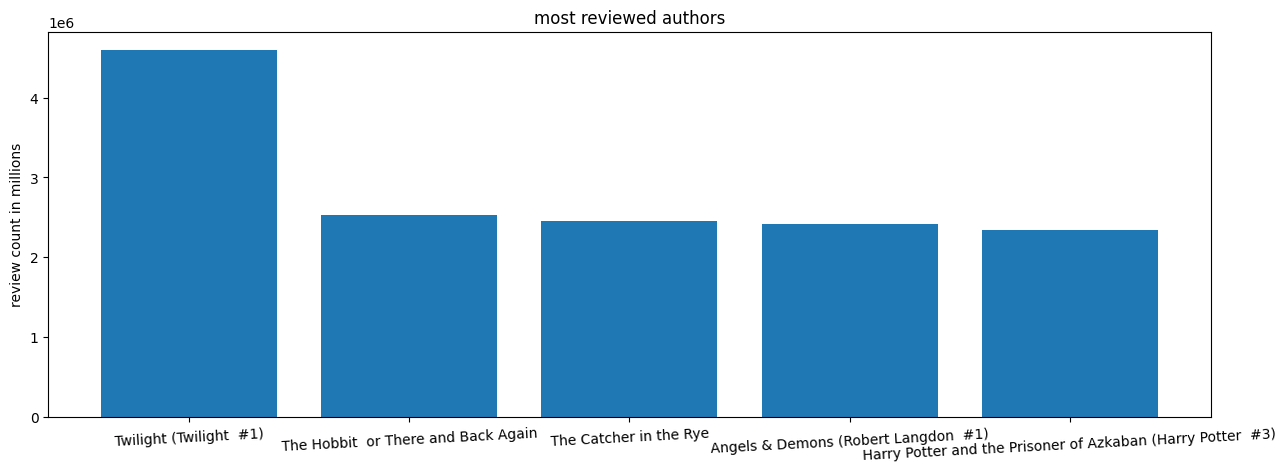

In [7]:

plt.figure(figsize=(15, 5))
plt.title('most reviewed authors')
plt.xticks(rotation=3)
plt.ylabel('review count in millions')

plt.bar(df.sort_values('ratings_count', ascending=False)['title'][:5], df.sort_values('ratings_count', ascending=False)['ratings_count'][:5])

Twilight has just over 4 million reviews. Something interesting here is that twilight is a series, having such a huge margin between itself and other books in the top 5, the discrepancy between twilight book 1 and any other book in the series must be huge. This tells us there are many people who did not read past the first book. 

<function matplotlib.pyplot.show(close=None, block=None)>

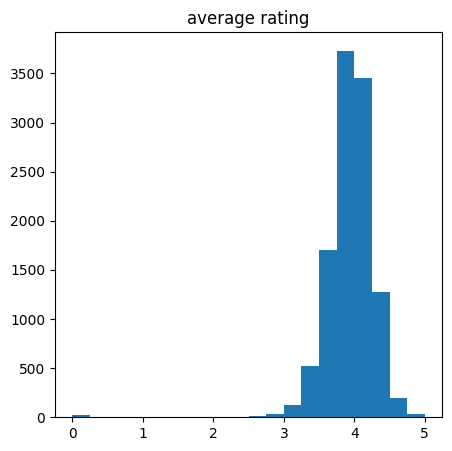

In [8]:
plt.figure(figsize=(5,5))
rating= df.average_rating.astype(float)
plt.title('average rating')
plt.hist(rating, bins=20)
plt.show

From this distribution we can tell that most ratings are clustered around 4 and anything near 5 or below 3 is very rare. Some observations: 

1. self-selection bias where people who finish books are more likely to
- have enjoyed the book enough to finish
- take the time to rate it
- rate it favorably based on their completion 
2. the very low frequency of ratings below 3 might indicate that people who don't enjoy books tend to:
- not finish them
- not rate them at all
- abandon them without leaving a low rating

The strong skew towards higher ratings (particularly around 4 stars) and the notable absence of lower ratings suggests that ratings may be biased towards readers who complete books, as those who abandon books they don't enjoy are less likely to provide ratings at all.

<function matplotlib.pyplot.show(close=None, block=None)>

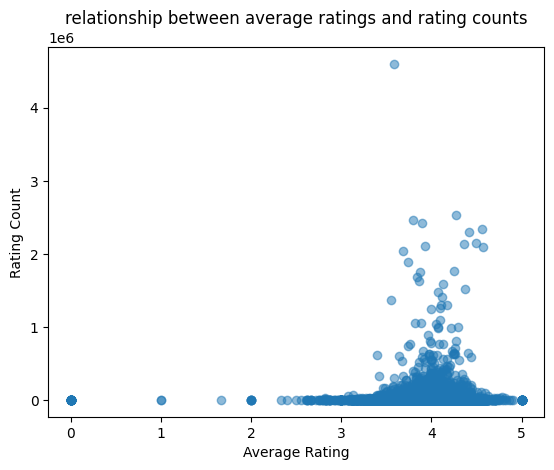

In [9]:
plt.scatter(df['average_rating'], df['ratings_count'], alpha=0.5)
plt.title('relationship between average ratings and rating counts')
plt.xlabel('Average Rating')
plt.ylabel('Rating Count')
plt.show

hard to discern a relationship, however, books with high rating counts tend to have above average ratings

# Recommender Model

### Normalizing numerical features

KNN is sensitive to feature scale, so we'll normalize values average_rating, num_pages, text_reviews_count, and ratings_count.

Before implementing the num_pages column into our feature set, we have to deal with whitespace that is producing errors 

In [10]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# checking for unusual characters in column names
for idx, col in enumerate(df.columns):
    print(f"Column {idx}: '{col}'")

df.columns = df.columns.str.strip() 

# to verify
print("Updated columns after reload:", df.columns)

numerical_features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']

# normalizing
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


Column 0: 'bookID'
Column 1: 'title'
Column 2: 'authors'
Column 3: 'average_rating'
Column 4: 'isbn'
Column 5: 'isbn13'
Column 6: 'language_code'
Column 7: '  num_pages'
Column 8: 'ratings_count'
Column 9: 'text_reviews_count'
Column 10: 'publication_date'
Column 11: 'publisher'
Updated columns after reload: Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')


In [11]:
# one hot encoding the 'language_code' column


encoder = OneHotEncoder(sparse_output=False, drop='first')  # 'drop=first' avoids multicollinearity
language_encoded = encoder.fit_transform(df[['language_code']])


language_encoded_df = pd.DataFrame(language_encoded, columns=encoder.get_feature_names_out(['language_code']), index=df.index) # Convert the encoded array back to a DataFrame with appropriate column names

# Concatenate the encoded languages with the normalized numerical features
final_features = pd.concat([df[numerical_features], language_encoded_df], axis=1)

final_features.head()


,average_rating,num_pages,ratings_count,text_reviews_count,language_code_ara,language_code_en-CA,language_code_en-GB,language_code_en-US,language_code_eng,language_code_enm,...,language_code_nl,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho
bookID,,,,,,,,,,,,,,,,,,,,,
1,0.914,0.099148,0.455816,0.292696,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.898,0.132299,0.468317,0.309988,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.884,0.053528,0.001377,0.002588,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.912,0.066150,0.508864,0.385350,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.956,0.409063,0.009011,0.001740,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will then build the model using cosine as the metric as it is generally best for recommender systems.

## Elbow Method to Find Optimal K

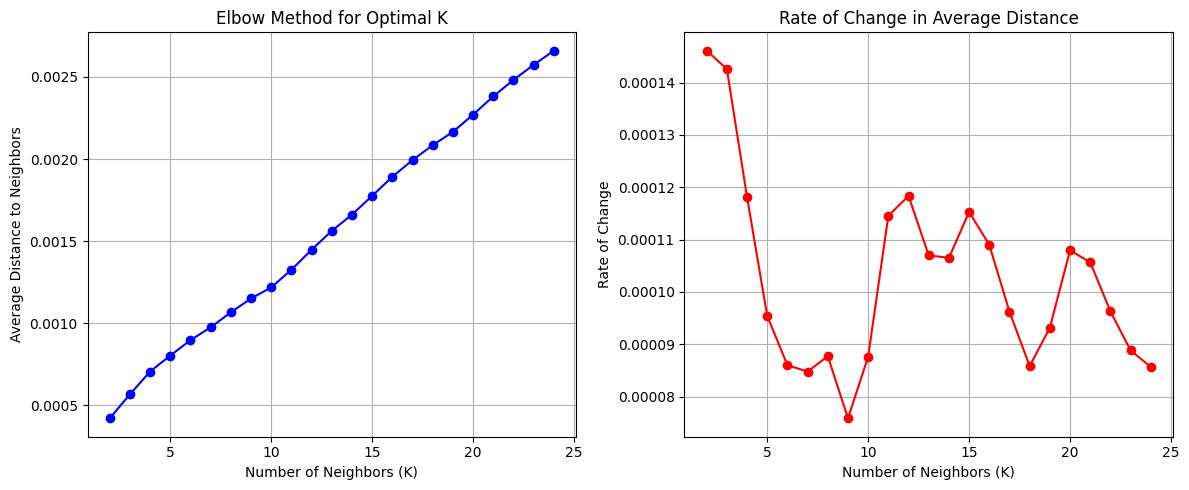

In [12]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


distances = []

# AVERAGE DISTANCES FOR EACH K
for k in range(2,25):
    neigh = NearestNeighbors(n_neighbors=k, metric='cosine')
    neigh.fit(final_features)
    avg_distance = np.mean(neigh.kneighbors(final_features)[0][:, 1:])
    distances.append(avg_distance)

# RATE OF CHANGE
derivatives = np.gradient(distances)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# DISTANCE PLOT
ax1.plot(range(2,25), distances, 'b-o')
ax1.set_xlabel('Number of Neighbors (K)')
ax1.set_ylabel('Average Distance to Neighbors')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# ROC PLOT
ax2.plot(range(2,25), derivatives, 'r-o')
ax2.set_xlabel('Number of Neighbors (K)')
ax2.set_ylabel('Rate of Change')
ax2.set_title('Rate of Change in Average Distance')
ax2.grid(True)

plt.tight_layout()
plt.show()

Using the traditional elbow method, we can see a uniform distribution with no clear 'elbow' to determine optimal K. The absence of a sharp elbow here is actually expected for a few reasons. 
- by now, features have been well standardized
- one hot encoding languages has created a sparse high-dimensional space
- book similarities tend to be naturally continuous rather than clustered

Fortunately, we can instead plot a rate of change, or derivative plot. This instead shows us how quickly the distances between points are changing - essentially measuring the 'speed' at which the first plot is rising. Instead of looking for an elbow here, we are looking for the ROC stabilizing. Our plot shows that the rate of change stabilizes around K=8, suggesting it is a good choice for K

In [13]:


knn_model = NearestNeighbors(n_neighbors=8, metric='cosine', algorithm='brute')
knn_model.fit(final_features)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=8)

In [14]:
def recommend_books(book_title, num_recommendations=5):
    # looks through data set to find closest match, also case insensitive

    potential_matches = df['title'].str.strip().str.lower()
    match = process.extractOne(book_title.lower(), potential_matches)

    print(f"Match result: {match}") 

    if not match:
        print(f"No match found for the book '{book_title}'.")
        return #handles no match error

    closest_title, score, _ = match #from fuzzy
    if score < 80:  # threshold, adjustable
        print(f"No sufficiently close match found for '{book_title}'. Closest match was '{closest_title}' with score {score}.")
        return

    # the index of the closest match
    book_idx = df.index[potential_matches == closest_title].tolist()

    print(f"Book indices found: {book_idx}") 
    if not book_idx:
        print(f"No book found with the title '{closest_title}'.")
        return

    book_idx = book_idx[0]  # Get the first match if there are duplicates

    
    if book_idx not in df.index:
        print(f"Index {book_idx} is not found in df.")
        return

    # Get the feature row for the selected book in final_features
    try:
        book_features = final_features.loc[book_idx].values.reshape(1, -1)
    except KeyError:
        print(f"Book index {book_idx} not found in final_features.")
        return

    # and then to find nearest neighbor
    distances, indices = knn_model.kneighbors(book_features, n_neighbors=num_recommendations + 1)

    
    recommended_books = []
    for idx in indices.flatten()[1:]:
        recommended_books.append(df.iloc[idx]['title'])

    print(f"Recommendations for '{closest_title}':")
    for i, title in enumerate(recommended_books, 1):
        print(f"{i}. {title}")



In [15]:
#USEAGE

recommend_books("no country for old men", num_recommendations=5)



Match result: ('no country for old men', 100, 12497)
Book indices found: [12497]
Recommendations for 'no country for old men':
1. Murder on the Orient Express (Hercule Poirot  #10)
2. My Life in France
3. Shutter Island
4. Magic Bites (Kate Daniels  #1)
5. In the Heart of the Sea: The Tragedy of the Whaleship Essex


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(



> [!WARNING]  
> THE WARNINGS ARE NOT AFFECTING RESULTS - it's just sklearn being picky about feature names consistency

In [16]:
#ALLOWS FOR INCOMPLETE BOOK TITLE

recommend_books("harry potter", num_recommendations=5)


Match result: ('harry potter and the half-blood prince (harry potter  #6)', 90, 1)
Book indices found: [1, 2005]
Recommendations for 'harry potter and the half-blood prince (harry potter  #6)':
1. Harry Potter and the Order of the Phoenix (Harry Potter  #5)
2. Harry Potter and the Chamber of Secrets (Harry Potter  #2)
3. Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
4. The Hobbit  or There and Back Again
5. Animal Farm


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [17]:
# ALLOWS FOR MISPELLING 

recommend_books('junie b jones', num_recommendations=5)

Match result: ('junie b. jones and a little monkey business (junie b. jones  #2)', 86, 1167)
Book indices found: [1167]
Recommendations for 'junie b. jones and a little monkey business (junie b. jones  #2)':
1. JLA  Vol. 1: New World Order
2. The Case of the Snowboarding Superstar (Jigsaw Jones  #29)
3. The School Skeleton (A to Z Mysteries  #19)
4. How Much is That Guinea Pig in the Window?
5. The OK Book


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [18]:
# MORE MISPELLING

recommend_books('the greats gatsby', num_recommendations=5)

Match result: ('the great gatsby', 97, 4673)
Book indices found: [4673, 4674, 4675, 4677, 14235, 27451]
Recommendations for 'the great gatsby':
1. Consider the Lilies
2. Thorn in Her Side (The Princess School  #7)
3. The Philadelphia Adventure
4. Three Men in a Boat: To Say Nothing of the Dog
5. Oddballs


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [19]:
# LANGUAGE SENSITIVE

recommend_books('la aventura de tom sawyer', num_recommendations=5)

Match result: ('las aventuras de tom sawyer', 96, 45641)
Book indices found: [45641]
Recommendations for 'las aventuras de tom sawyer':
1. Como agua para chocolate
2. Carrie (Biblioteca de Stephen King. 102  8)
3. Carrie
4. Encuentro en el Ártico (Artemis Fowl  #2)
5. La verdad acerca de las Industrias Farmacéuticas: cómo nos engaña y qué hacer al respecto


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [21]:
recommend_books('to kill a mockingbird', num_recommendations=5)

Match result: ('to kill a mockingbird', 98, 2654)
Book indices found: [2654, 2655, 2661]
Recommendations for 'to kill a mockingbird':
1. There are No Children Here: The Story of Two Boys Growing Up in the Other America
2. In Harm's Way: The Sinking of the USS Indianapolis and the Extraordinary Story of Its Survivors
3. Fermat's Enigma: The Epic Quest to Solve the World's Greatest Mathematical Problem
4. Mandy
5. Memoirs of Hadrian


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
